# Evaluating loaded heatmaps

In [1]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import os
import transformers
from accelerate import Accelerator
from transformers import ViTImageProcessor, ViTForImageClassification, ViTModel, ViTConfig, TrainingArguments, Trainer
from PIL import Image
import requests
import matplotlib.pyplot as plt
import numpy as np
import cv2
from datasets import load_dataset,load_metric
from torchvision.transforms import (
    CenterCrop,
    Compose,
    Normalize,
    RandomHorizontalFlip,
    RandomResizedCrop,
    Resize,
    ToTensor,
)

accelerator = Accelerator()
device = accelerator.device

/opt/crc/c/conda/23.5.2/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


# Load Model

In [2]:
# url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
# url = "http://farm3.staticflickr.com/2066/1798910782_5536af8767_z.jpg"
# url = "http://farm1.staticflickr.com/184/399924547_98e6cef97a_z.jpg"
url = "http://farm1.staticflickr.com/128/318959350_1a39aae18c_z.jpg"
image = Image.open(requests.get(url, stream=True).raw)

pretrained_name = 'google/vit-base-patch16-224'
# pretrained_name = 'vit-base-patch16-224-finetuned-imageneteval'
# pretrained_name = 'openai/clip-vit-base-patch32'
config = ViTConfig.from_pretrained(pretrained_name)
processor = ViTImageProcessor.from_pretrained(pretrained_name)
# get mean and std to unnormalize the processed images
mean, std = processor.image_mean, processor.image_std

pred_model = ViTForImageClassification.from_pretrained(pretrained_name)
pred_model.to(device)
# set to eval mode
pred_model.eval()

inputs = processor(images=image, return_tensors="pt")
inputs.to(device)
outputs = pred_model(**inputs, output_hidden_states=True)
logits = outputs.logits
# model predicts one of the 1000 ImageNet classes
predicted_class_idx = logits.argmax(-1).item()
print("Predicted class:", pred_model.config.id2label[predicted_class_idx])

Predicted class: golden retriever


# Load test data

In [3]:
from torch.utils.data import DataLoader
def load_data(seed=42): 
    dataset = load_dataset("mrm8488/ImageNet1K-val")
    dataset = dataset['train']
    splits = dataset.train_test_split(test_size=0.1, seed=seed)
    test_ds = splits['test']
    splits = splits['train'].train_test_split(test_size=0.1, seed=seed)
    train_ds = splits['train']
    val_ds = splits['test']
    return train_ds, val_ds, test_ds

_, _, test_ds = load_data()

normalize = Normalize(mean=processor.image_mean, std=processor.image_std)
if "height" in processor.size:
    size = (processor.size["height"], processor.size["width"])
    crop_size = size
    max_size = None
elif "shortest_edge" in processor.size:
    size = processor.size["shortest_edge"]
    crop_size = (size, size)
    max_size = processor.size.get("longest_edge")

transforms = Compose(
        [
            Resize(size),
            CenterCrop(crop_size),
            ToTensor(),
            normalize,
        ]
    )

def preprocess(example_batch):
    """Apply val_transforms across a batch."""
    example_batch["pixel_values"] = [transforms(image.convert("RGB")) for image in example_batch["image"]]
    return example_batch

def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

test_ds.set_transform(preprocess)

# batch size is limited to 2, because n_steps could could huge memory consumption
batch_size = 100
test_dataloader = DataLoader(test_ds, batch_size=batch_size, collate_fn=collate_fn, shuffle=False)

Repo card metadata block was not found. Setting CardData to empty.


# Load heatmaps

In [4]:
from evaluation import EvalGame
import os 
import re
from tqdm import tqdm


# root_path = 'results/maskgen-vit-4epoch'
root_path = 'results/rise-2000-vit'
model = lambda x: pred_model(pixel_values=x).logits
eval_game = EvalGame(model=lambda x : pred_model(pixel_values=x).logits, output_dim=1000)
topk = 10

def extract_number(filename):
    """
    Extract the first occurance of countinuous numbers in a file name
    """
    match = re.search(r'\d+', filename)
    if match:
        return int(match.group(0))
    return 0

def get_ordered_filename_list(root_path):
    file_path_list = []
    for filename in os.listdir(root_path):
        if filename.endswith('.npy'):
            file_path = os.path.join(root_path, filename)
            file_path_list.append(file_path)
    file_path_list = sorted(file_path_list, key=extract_number)
    return file_path_list


def load_heatmap(root_path):
    file_path_list = get_ordered_filename_list(root_path)
    for filename in file_path_list:
       yield np.load(filename)


ins_score_list = []
del_score_list = []

heatmap_generator = load_heatmap(root_path)
test_dataloader_iterator = iter(test_dataloader)
for idx, data in tqdm(enumerate(heatmap_generator)):
    heatmap = torch.tensor(data, device=device)

    with torch.no_grad():
        # Average pooling to convert to 14*14 heatmap
        if root_path == 'results/ig-vit':
             heatmap = F.avg_pool2d(heatmap, kernel_size=16, stride=16)
        input_img = next(test_dataloader_iterator)['pixel_values'].to(device)

        pseudo_label = pred_model(input_img).logits.argmax(-1).view(-1)
        ins_score = eval_game.get_insertion_at_topk(input_img, heatmap, topk).detach()
        del_score = eval_game.get_deletion_at_topk(input_img, heatmap, topk).detach()

        # append to list
        ins_score_list.append(ins_score)
        del_score_list.append(del_score)
    if idx >= 10:
        break

10it [00:31,  3.19s/it]


In [5]:
ins_score = torch.cat(ins_score_list, dim=0)
del_score = torch.cat(del_score_list, dim=0)
print(ins_score.mean())
print(del_score.mean())

tensor(0.4482, device='cuda:0')
tensor(0.5573, device='cuda:0')


Predicted class: sea lion


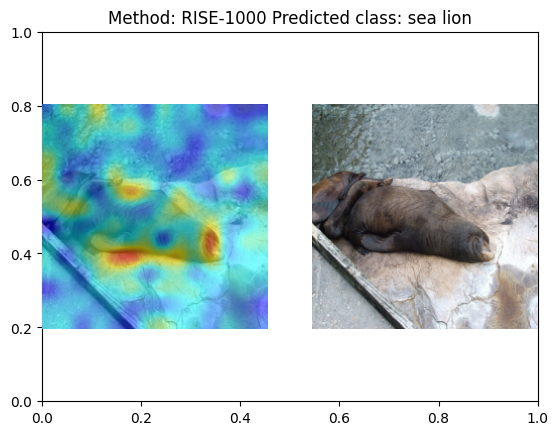

ins_score: tensor(0.9805, device='cuda:0')
del_score: tensor(0.0011, device='cuda:0')


In [6]:
from utils.img_utils import plot_overlap_np

idx = 32

predicted_class_idx = pseudo_label[idx].item()
print("Predicted class:", pred_model.config.id2label[predicted_class_idx])

hm = heatmap[idx].detach().cpu().numpy()
img = input_img[idx].detach().cpu().numpy().transpose(1, 2, 0)

plt.title(f"Method: RISE-1000 Predicted class: {pred_model.config.id2label[predicted_class_idx]}")
plt.annotate(f"ins_score: {ins_score_list[-1][idx]:.4f}", (0, 10))
plt.annotate(f"del_score: {del_score_list[-1][idx]:.4f}", (0, 20))
img_int, heatmap_img = plot_overlap_np(img, hm, mean, std)

print("ins_score:", ins_score_list[-1][idx])
print("del_score:", del_score_list[-1][idx])

In [7]:
heatmap.shape

torch.Size([100, 14, 14])